In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..\..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import numpy as np
import pandas as pd

from jax import vmap, grad, jit
import jax.numpy as jnp
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science','no-latex'])

from jaxfin.models.heston import UnivHestonModel
from jaxfin.price_engine.black_scholes import gamma_european
from jaxfin.price_engine.fft import fourier_inv_call, delta_call_fourier

from src.experimental.bs_iv import IV_brent
import py_vollib_vectorized

In [3]:
seed = 42
np.random.seed(seed)

$$
S(0) = 100 \\
\sigma = 0.2 \\
\mu = 0.00 \\
$$

Let set $N = 252$, which means that we are rebalancing our portfolio daily.

In [44]:
# Initialize the Univariate Heston Model
s0 = 100.0
v0 = 0.04
mu = 0.0
kappa = 1.0
theta = 0.04
sigma = 0.1
rho = -0.7

heston_model = UnivHestonModel(s0, v0, mu, kappa, theta, sigma, rho)

In [45]:
maturity = 0.5
N = 121
n_sim = 100

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

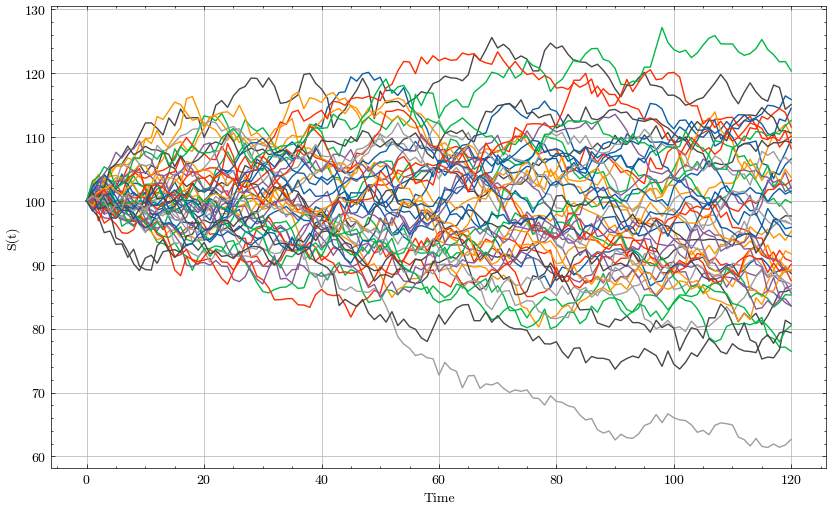

In [46]:
plt.figure(figsize=(10, 6))
plt.plot(stock_paths[:, :50])
plt.ylabel('S(t)')
plt.xlabel('Time')
plt.grid()
plt.show()

In [47]:
discount_rate = 0.0
dividends = 0.0

## Hedging experiment without transaction costs

In [48]:
ticksize = 0.00
K = 100
maturity = 0.5
N = 121
n_sim = 100
ticksize = 0.05

v_gamma_european = vmap(gamma_european, in_axes=(0, None, None, None, None))
v_v_gamma_european = vmap(v_gamma_european, in_axes=(None, None, None, 0, None))
v_fourier_delta_call = vmap(delta_call_fourier, in_axes=(0, None, None, None, None, None, None, None, None))
v_v_fourier_delta_call = vmap(v_fourier_delta_call, in_axes=(None, None, None, 0, None, None, None, None, None))
v_fourier_inv_call = vmap(fourier_inv_call, in_axes=(0, None, None, None, None, None, None, None, None))
v_v_fourier_inv_call = vmap(v_fourier_inv_call, in_axes=(None, None, None, 0, None, None, None, None, None))

In [49]:
def heston_vega(s0, K, T, v, mu, theta, sigma, kappa, rho):
    return grad(fourier_inv_call, argnums=3)(s0, K, T, v, mu, theta, sigma, kappa, rho)

_v_heston_vega = vmap(heston_vega, in_axes=(0, None, None, None, None, None, None, None, None))
v_heston_vega = vmap(_v_heston_vega, in_axes=(None, None, None, 0, None, None, None, None, None))

In [50]:
def get_heston_deltas(stock_paths, var_process, K, T, mu, theta, sigma, kappa, rho, N):
    dt = maturity / N
    deltas = [v_v_fourier_delta_call(stock_paths[0], K, T, var_process[0], mu, theta, sigma, kappa, rho).diagonal()]
    deltas_ = [v_v_fourier_delta_call(
        stock_paths[i], 
        K, 
        T - i * dt, 
        var_process[i - 1], 
        mu, 
        theta, 
        sigma, 
        kappa, 
        rho).diagonal() for i in range(1, N)]
    return jnp.asarray(deltas + deltas_)

def get_heston_vegas(stock_paths, var_process, K, T, mu, theta, sigma, kappa, rho, N):
    dt = maturity / N
    vegas = [v_heston_vega(stock_paths[0], K, T, var_process[0], mu, theta, sigma, kappa, rho).diagonal()]
    vegas_ = [v_heston_vega(
        stock_paths[i], 
        K, 
        T - i * dt, 
        var_process[i - 1], 
        mu, 
        theta, 
        sigma, 
        kappa, 
        rho).diagonal() for i in range(1, N)]
    return jnp.asarray(vegas + vegas_)

def get_heston_hedging_deltas(stock_paths, var_process, K, T, mu, theta, sigma, kappa, rho, N):
    vegas = get_heston_vegas(stock_paths, var_process, K, T, mu, theta, sigma, kappa, rho, N)
    deltas = get_heston_deltas(stock_paths, var_process, K, T, mu, theta, sigma, kappa, rho, N)

    return deltas + (rho * sigma / stock_paths) * vegas


In [51]:
def get_transaction_costs(ticksize, ddelta):
    return ticksize * (jnp.abs(ddelta) + 0.01 * ddelta**2)

In [52]:
def rehedge(current_delta, bs_delta, time_to_exp, kappa, s_t, gamma):
    rhs = (1.5 * ((np.exp(-0.0*time_to_exp) * kappa * s_t * gamma**2) / 2.0))**(1/3)
    return ~(np.abs(current_delta - bs_delta) > rhs)

def willmot_delta(current_delta, bs_delta, time_to_exp, kappa, s_t, gamma):
    condition =  rehedge(current_delta, bs_delta, time_to_exp, kappa, s_t, gamma)    
    return current_delta.at[:].set(jnp.where(condition, bs_delta[:], current_delta[:]))

In [53]:
dt = maturity / N
deltas = get_heston_hedging_deltas(stock_paths, var_process, K, maturity, mu, theta, sigma, kappa, rho, N)
gammas = [v_v_gamma_european(stock_paths[i], K, maturity - i * dt, jnp.sqrt(var_process[i]), discount_rate).diagonal() for i in range(0, N)]
cs = [v_v_fourier_inv_call(stock_paths[i], K, maturity - i * dt, var_process[i], mu, theta, sigma, kappa, rho).diagonal() for i in range(0, N)]
b = [cs[0] - deltas[0] * stock_paths[0]]
vs = [cs[0]]
previous_delta = deltas[0]
current_delta = deltas[0]

for i in range(1, N):
    current_delta = willmot_delta(current_delta, deltas[i], maturity - i * dt, ticksize, stock_paths[i], gammas[i])
    ddelta = current_delta - previous_delta
    transaction_costs = get_transaction_costs(ticksize, ddelta)

    vs.append(previous_delta * stock_paths[i] + b[i - 1])
        
    previous_delta = current_delta

    b.append(vs[i] - (current_delta + transaction_costs) * stock_paths[i])
        
hedge_error = jnp.asarray(vs) - jnp.maximum(stock_paths - K, 0)

In [54]:
print(f'The mean hedge error is: {jnp.mean(hedge_error[-1]) / jnp.asarray(cs)[0, 0]}')
print(f'The normalized std of the hedge error is: {jnp.std(hedge_error[-1]) / jnp.asarray(cs)[0, 0]}')

The mean hedge error is: -3.0578906536102295
The normalized std of the hedge error is: 1.0691816806793213


In [55]:
maturity = 0.5
N = 26
n_sim = 100

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [56]:
dt = maturity / N
deltas = get_heston_hedging_deltas(stock_paths, var_process, K, maturity, mu, theta, sigma, kappa, rho, N)
cs = [v_v_fourier_inv_call(stock_paths[i], K, maturity - i * dt, var_process[i], mu, theta, sigma, kappa, rho).diagonal() for i in range(0, N)]
b = [cs[0] - deltas[0] * stock_paths[0]]
vs = [cs[0]]

for i in range(1, N):
    ddelta = deltas[i] - deltas[i - 1]
    transaction_costs = get_transaction_costs(ticksize, ddelta)

    vs.append(deltas[i - 1] * stock_paths[i] + b[i - 1])
    b.append(vs[i] - (deltas[i] + transaction_costs) * stock_paths[i])
        
hedge_error = jnp.asarray(vs) - jnp.maximum(stock_paths - K, 0)

In [57]:
print(f'The mean hedge error is: {jnp.mean(hedge_error[-1]) / jnp.asarray(cs)[0, 0]}')
print(f'The normalized std of the hedge error is: {jnp.std(hedge_error[-1]) / jnp.asarray(cs)[0, 0]}')

The mean hedge error is: -1.2958955764770508
The normalized std of the hedge error is: 0.4567929804325104


In [58]:
maturity = 0.2
N = 50
n_sim = 100

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [59]:
dt = maturity / N
deltas = get_heston_hedging_deltas(stock_paths, var_process, K, maturity, mu, theta, sigma, kappa, rho, N)
cs = [v_v_fourier_inv_call(stock_paths[i], K, maturity - i * dt, var_process[i], mu, theta, sigma, kappa, rho).diagonal() for i in range(0, N)]
b = [cs[0] - deltas[0] * stock_paths[0]]
vs = [cs[0]]

for i in range(1, N):
    ddelta = deltas[i] - deltas[i - 1]
    transaction_costs = get_transaction_costs(ticksize, ddelta)

    vs.append(deltas[i - 1] * stock_paths[i] + b[i - 1])
    b.append(vs[i] - (deltas[i] + transaction_costs) * stock_paths[i])
        
hedge_error = jnp.asarray(vs) - jnp.maximum(stock_paths - K, 0)

In [60]:
print(f'The mean hedge error is: {jnp.mean(hedge_error[-1]) / jnp.asarray(cs)[0, 0]}')
print(f'The normalized std of the hedge error is: {jnp.std(hedge_error[-1]) / jnp.asarray(cs)[0, 0]}')

The mean hedge error is: -3.1650190353393555
The normalized std of the hedge error is: 1.0703939199447632


In [61]:
maturity = 0.2
N = 10
n_sim = 100

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [62]:
dt = maturity / N
deltas = get_heston_hedging_deltas(stock_paths, var_process, K, maturity, mu, theta, sigma, kappa, rho, N)
cs = [v_v_fourier_inv_call(stock_paths[i], K, maturity - i * dt, var_process[i], mu, theta, sigma, kappa, rho).diagonal() for i in range(0, N)]
b = [cs[0] - deltas[0] * stock_paths[0]]
vs = [cs[0]]

for i in range(1, N):
    ddelta = deltas[i] - deltas[i - 1]
    transaction_costs = get_transaction_costs(ticksize, ddelta)

    vs.append(deltas[i - 1] * stock_paths[i] + b[i - 1])
    b.append(vs[i] - (deltas[i] + transaction_costs) * stock_paths[i])
        
hedge_error = jnp.asarray(vs) - jnp.maximum(stock_paths - K, 0)

In [63]:
print(f'The mean hedge error is: {jnp.mean(hedge_error[-1]) / jnp.asarray(cs)[0, 0]}')
print(f'The normalized std of the hedge error is: {jnp.std(hedge_error[-1]) / jnp.asarray(cs)[0, 0]}')

The mean hedge error is: -1.1606552600860596
The normalized std of the hedge error is: 0.5504575967788696
